In [1]:
import testImageDecorrelation as tid
import imageDecorrelation as id
import diffimTests as dit

reload(id)
reload(tid)
reload(dit)

import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

Template PSF: [2.2, 2.2] 0.0
Science PSF: [3.3, 3.3] 0.0
2.45967477525
Offset: [0.0, 0.0]
PSF y spatial-variation: 0.0 0.0


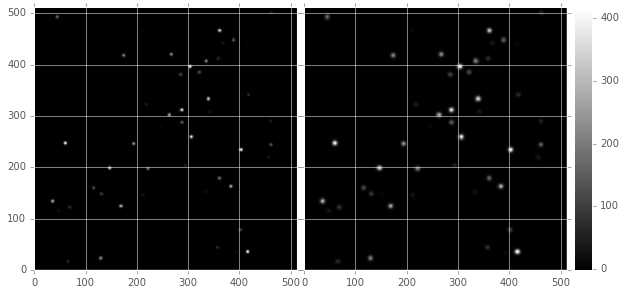

In [2]:
psf1_sigma = 2.2  # sigma of psf of template image
psf2_sigma = 3.3  # sigma of psf of science image
sig1 = 0.2  # std.dev of noise in template image
sig2 = 0.2  # std.dev of noise in science image

im1ex, im2ex \
    = tid.makeFakeImages(sig1=sig1, sig2=sig2, psf1=psf1_sigma, psf2=psf2_sigma,
                     n_sources=50, verbose=True)
dit.plotImageGrid((im1ex, im2ex), imScale=5)

('Expected variance:', 0.08000000000000002)
0.0404769022669


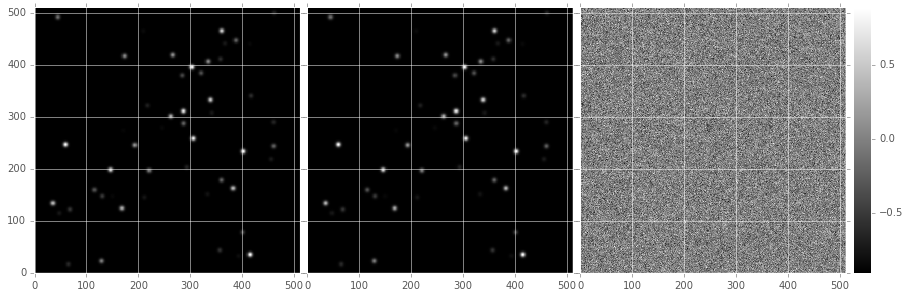

In [3]:
import lsst.meas.algorithms as measAlg

psf1_sig = im1ex.getPsf().computeShape().getDeterminantRadius()
psf2_sig = im2ex.getPsf().computeShape().getDeterminantRadius()
sig_match = np.sqrt((psf2_sig**2. - psf1_sig**2.))
matchingKernel = measAlg.SingleGaussianPsf(31, 31, sig_match)

# Create the matched template by convolving the template with the matchingKernel
from scipy.ndimage.filters import convolve
im1 = im1ex.getMaskedImage().getImage().getArray()
matched_im1 = convolve(im1, matchingKernel.computeImage().getArray(), mode='constant')
matched_im1ex = im1ex.clone()
matched_im1ex.getMaskedImage().getImage().getArray()[:, :] = matched_im1

# Expected (ideal) variance of difference image
expected_var = sig1**2 + sig2**2
print('Expected variance:', expected_var)

im2 = im2ex.getMaskedImage().getImage().getArray()
print((matched_im1 - im2).var())

dit.plotImageGrid((matched_im1, im2, matched_im1-im2), imScale=5)

0.0765462726139


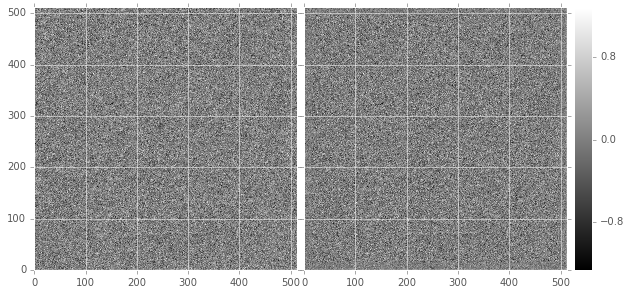

In [4]:
import lsst.pex.logging as pexLog

diffExp = matched_im1ex.clone()
tmpArr = diffExp.getMaskedImage().getImage().getArray()
tmpArr -= im2ex.getMaskedImage().getImage().getArray()

log = pexLog.Log(pexLog.Log.getDefaultLog(), 'testImageDecorrelation', pexLog.Log.INFO)
# This corrects the diffExp in-place:
corrected_diffExp, _ = id.decorrelateExposure(im1ex, im2ex, diffExp, matchingKernel, log)

corrected_diffArr = corrected_diffExp.getMaskedImage().getImage().getArray()
print(corrected_diffArr.var())
dit.plotImageGrid((diffExp, corrected_diffExp), imScale=5)

(32, 32) (16, 16)
(32, 32) (16, 16)


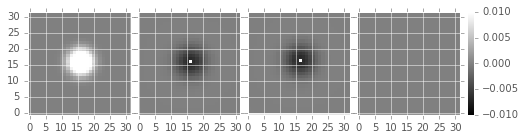

In [5]:
import lsst.afw.image as afwImage
reload(dit)
reload(id)
#matchingKernel = measAlg.SingleGaussianPsf(30, 30, sig_match)
#mc = matchingKernel.computeImage().getArray()
#print mc.shape, matchingKernel.computeImage().getBBox(), np.unravel_index(np.argmax(mc), mc.shape)

x0 = np.arange(-16, 16, 1)
y0 = x0.copy()
x0im, y0im = np.meshgrid(x0, y0)
matchingKernel = tid.singleGaussian2d(x0im, y0im, 0., 0., sigma_x=sig_match, sigma_y=sig_match)
print matchingKernel.shape, np.unravel_index(np.argmax(matchingKernel), matchingKernel.shape)

corrKernel = id.computeDecorrelationKernel(matchingKernel, sig1=sig1, sig2=sig2)
print corrKernel.shape, np.unravel_index(np.argmax(corrKernel), corrKernel.shape)
#kernelImg = afwImage.ImageD(corrKernel)
kernelImg = afwImage.ImageD(corrKernel.shape[0], corrKernel.shape[1])
kernelImg.getArray()[:, :] = corrKernel
dit.plotImageGrid((matchingKernel, corrKernel, kernelImg, corrKernel-kernelImg.getArray()), 
                  clim=(-0.01,0.01), nrows_ncols=(1,4))

(512, 512) (85, 401)
(512, 512) (382, 115)
(512, 512) (382, 115)
0.0798278359027
0.0798278359027


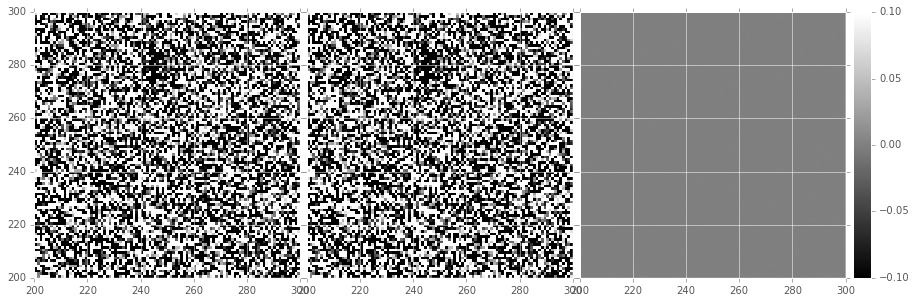

In [6]:
reload(id)
reload(dit)
#diffExp.getMaskedImage().getImage().getArray()[256,256] = 100.
fcorrKernel = id.fixEvenKernel(corrKernel)
correctedExposure1, _ = id.doConvolve(diffExp, fcorrKernel, True)
correctedExposure2, _ = id.doConvolve(diffExp, fcorrKernel, False)

tmp = diffExp.getMaskedImage().getImage().getArray()
print tmp.shape, np.unravel_index(np.argmax(tmp), tmp.shape)
tmp = correctedExposure1.getMaskedImage().getImage().getArray()
print tmp.shape, np.unravel_index(np.argmax(np.nan_to_num(tmp)), tmp.shape)
tmp = correctedExposure2.getMaskedImage().getImage().getArray()
print tmp.shape, np.unravel_index(np.argmax(np.nan_to_num(tmp)), tmp.shape)

corrected_diffArr1 = correctedExposure1.getMaskedImage().getImage().getArray()
print(corrected_diffArr1[~np.isnan(corrected_diffArr1)].var())
corrected_diffArr2 = correctedExposure2.getMaskedImage().getImage().getArray()

diff = corrected_diffArr1 - corrected_diffArr2
#diff = corrected_diffArr1[1:, 1:] - corrected_diffArr2[:-1, :-1]

corrected_diffArr2 = corrected_diffArr2[15:-15, 15:-15]
print(corrected_diffArr2[~np.isnan(corrected_diffArr2)].var())

dit.plotImageGrid((correctedExposure1, correctedExposure2, diff), imScale=5., 
                  extent=(200,300,200,300), clim=(-0.1,0.1))

0.00176202471352
0.00536387842029
0.181367482691


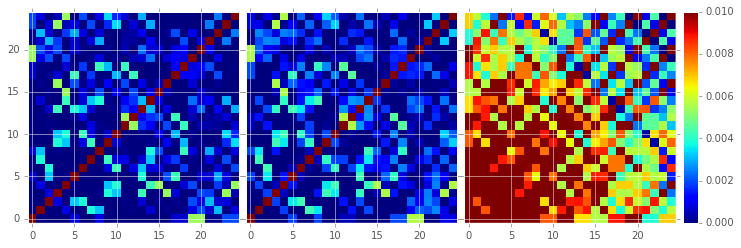

In [12]:
cov1 = dit.computePixelCovariance(np.nan_to_num(corrected_diffArr1))
cov2 = dit.computePixelCovariance(np.nan_to_num(corrected_diffArr2[14:-14, 14:-14]))
cov3 = dit.computePixelCovariance(diffExp.getMaskedImage().getImage().getArray())
dit.plotImageGrid((cov1, cov2, cov3), cmap=None, imScale=4., clim=(0., 0.01))

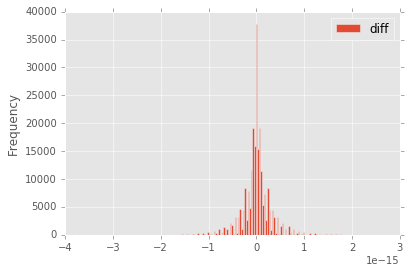

In [8]:
import pandas as pd
df = pd.DataFrame({'diff': diff.flatten()})
df.plot.hist(bins=200)

/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0
  'bottom=%s, top=%s') % (bottom, top))


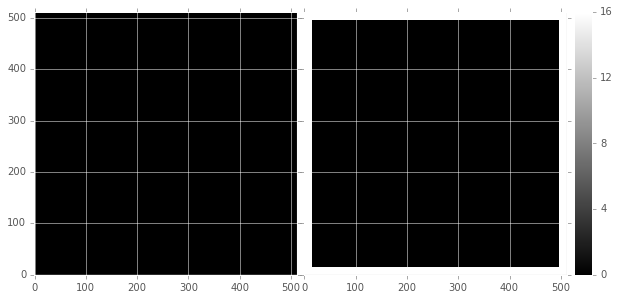

In [9]:
dit.plotImageGrid((correctedExposure1.getMaskedImage().getMask().getArray(), 
                   correctedExposure2.getMaskedImage().getMask().getArray()), imScale=5.)

In [10]:
print correctedExposure2.getMaskedImage().getMask().getArray()[100, 0:40]
print correctedExposure2.getMaskedImage().getMask().getArray()[0:40, 100]
mask = correctedExposure2.getMaskedImage().getMask()
dir(mask)
dct = mask.getMaskPlaneDict()
dct['EDGE']

[16 16 16 16 16 16 16 16 16 16 16 16 16 16 16  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[16 16 16 16 16 16 16 16 16 16 16 16 16 16 16  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


4

In [11]:
afwImage.MaskU.getPlaneBitMask(["EDGE"])

16